In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Callable, Dict, List, Tuple, Any

try:
    import scipy.optimize as spo
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.max_columns", 50)

def set_seed(seed: int = 42):
    np.random.seed(seed)


In [23]:

def synthetic_profiles(T=24, K_s=100.0, K_r=80.0, seed=42):
    rng = np.random.default_rng(seed)
    h = np.arange(T)

    base = 500 + 120*np.sin(2*np.pi*(h-16)/24)
    noise = rng.normal(0, 15, size=T)
    D = np.maximum(base + noise, 100)

    day = np.maximum(0, np.sin(np.pi*(h-6)/12))
    cloud = rng.lognormal(mean=0.0, sigma=0.15, size=T)
    solar_profile = np.clip(day * cloud, 0, 1.2)
    g_s = K_s * np.clip(solar_profile, 0, 1.0)

    mu = 0.35 + 0.15*np.sin(2*np.pi*(h+4)/24)
    eps = rng.normal(0, 0.08, size=T)
    a_r = np.clip(mu + eps, 0.0, 1.0)
    g_r = K_r * a_r

    return D, g_s, g_r

def cost_total(gn, u, c, c1=200.0, c2=1.0, pi_u=10000.0, pi_c=10.0, gamma=0.0):
    gn = np.asarray(gn); u = np.asarray(u); c = np.asarray(c)
    termica = np.sum(c1*gn + 0.5*c2*gn**2)
    pen = np.sum(pi_u*u + pi_c*c)
    ramp = gamma * np.sum((gn[1:] - gn[:-1])**2) if gamma > 0 else 0.0
    return float(termica + pen + ramp)

def solve_dispatch_closed_form(D, gs, gr, K_n=150.0, c1=200.0, c2=1.0, pi_u=10000.0, pi_c=10.0):
    T = len(D)
    gn = np.zeros(T); u = np.zeros(T); c = np.zeros(T)
    for t in range(T):
        resid = D[t] - (gs[t] + gr[t])
        if resid >= 0:
            # unconstrained stationary point for gamma=0 (one-period)
            gn_star = max(0.0, (pi_u - c1)/c2)
            gn_t = min(K_n, min(resid, gn_star))
            u_t = resid - gn_t
            c_t = 0.0
        else:
            gn_t = 0.0
            u_t = 0.0
            c_t = -resid
        gn[t], u[t], c[t] = gn_t, u_t, c_t
    return gn, u, c

def solve_dispatch_numeric(D, gs, gr, K_n=150.0, c1=200.0, c2=1.0, pi_u=10000.0, pi_c=10.0, gamma=1.0):
    T = len(D)
    if (not SCIPY_AVAILABLE) or gamma <= 0:
        return solve_dispatch_closed_form(D, gs, gr, K_n=K_n, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c)

    def unpack(x):
        gn = x[:T]; u = x[T:2*T]; c = x[2*T:3*T]
        return gn, u, c

    def fobj(x):
        gn, u, c = unpack(x)
        return cost_total(gn, u, c, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c, gamma=gamma)

    rhs = D - (gs + gr)
    def cons_fun(x):
        gn, u, c = unpack(x)
        return gn - c + u - rhs

    cons = ({'type': 'eq', 'fun': cons_fun},)
    bounds = [(0.0, K_n)]*T + [(0.0, None)]*T + [(0.0, None)]*T

    gn0 = np.clip(rhs, 0.0, K_n)
    u0 = np.clip(-gn0 + rhs, 0.0, None)
    c0 = np.clip(gn0 - rhs, 0.0, None)
    x0 = np.concatenate([gn0, u0, c0])

    res = spo.minimize(fobj, x0, method='SLSQP', bounds=bounds, constraints=cons,
                       options={'maxiter': 500, 'ftol': 1e-9})
    if not res.success:
        return solve_dispatch_closed_form(D, gs, gr, K_n=K_n, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c)
    return unpack(res.x)

def estimate_lambda(D, gs, gr, gn, u, c, c1=200.0, c2=1.0, pi_u=10000.0, pi_c=10.0, gamma=0.0,
                    solver='auto', K_n=150.0, eps=1e-3):
    T = len(D)
    lam = np.zeros(T)
    base_cost = cost_total(gn, u, c, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c, gamma=gamma)
    for t in range(T):
        Dp = D.copy(); Dp[t] += eps
        if solver == 'numeric' and gamma > 0 and SCIPY_AVAILABLE:
            gn_p, u_p, c_p = solve_dispatch_numeric(Dp, gs, gr, K_n=K_n, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c, gamma=gamma)
        else:
            gn_p, u_p, c_p = solve_dispatch_closed_form(Dp, gs, gr, K_n=K_n, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c)
        cost_p = cost_total(gn_p, u_p, c_p, c1=c1, c2=c2, pi_u=pi_u, pi_c=pi_c, gamma=gamma)
        lam[t] = (cost_p - base_cost)/eps
    return lam

def classify_regime(u, c, tol=1e-9):
    reg = np.full(u.shape, 'interior', dtype=object)
    reg[u > tol] = 'deficit'
    reg[(u <= tol) & (c > tol)] = 'excesso'
    return reg


In [24]:

@dataclass
class Params:
    T: int = 24
    K_s: float = 100.0
    K_r: float = 80.0
    K_n: float = 150.0
    c1: float = 200.0
    c2: float = 1.0
    pi_u: float = 10000.0
    pi_c: float = 10.0
    gamma: float = 0.0
    seed: int = 42

def run_scenario(p: Params, name: str = "Scenario") -> Tuple[pd.DataFrame, Dict[str, Any]]:
    D, gs, gr = synthetic_profiles(T=p.T, K_s=p.K_s, K_r=p.K_r, seed=p.seed)
    if p.gamma > 0 and SCIPY_AVAILABLE:
        gn, u, c = solve_dispatch_numeric(D, gs, gr, K_n=p.K_n, c1=p.c1, c2=p.c2, pi_u=p.pi_u, pi_c=p.pi_c, gamma=p.gamma)
        solver_used = 'numeric'
    else:
        gn, u, c = solve_dispatch_closed_form(D, gs, gr, K_n=p.K_n, c1=p.c1, c2=p.c2, pi_u=p.pi_u, pi_c=p.pi_c)
        solver_used = 'closed-form'
    lam = estimate_lambda(D, gs, gr, gn, u, c, c1=p.c1, c2=p.c2, pi_u=p.pi_u, pi_c=p.pi_c, gamma=p.gamma,
                          solver=solver_used, K_n=p.K_n, eps=1e-3)
    regime = classify_regime(u, c, tol=1e-9)

    df = pd.DataFrame({
        't': np.arange(p.T), 'D': D, 'g_s': gs, 'g_r': gr,
        'g_n': gn, 'u': u, 'c': c, 'lambda': lam, 'regime': regime
    })

    pct_def = float((regime == 'deficit').mean())
    pct_exc = float((regime == 'excesso').mean())
    pct_int = float((regime == 'interior').mean())

    summary = {
        'cenario': name, **asdict(p),
        'custo_total': cost_total(gn, u, c, c1=p.c1, c2=p.c2, pi_u=p.pi_u, pi_c=p.pi_c, gamma=p.gamma),
        'energia_nao_suprida': u.sum(),
        'curtailment_total': c.sum(),
        'lambda_medio': float(lam.mean()),
        'lambda_p95': float(np.percentile(lam, 95)),
        'pct_deficit': pct_def, 'pct_interior': pct_int, 'pct_excesso': pct_exc
    }
    return df, summary

def check_feasibility(df: pd.DataFrame, tol: float = 1e-6) -> Dict[str, Any]:
    resid = df['g_n'] + df['g_s'] + df['g_r'] - (df['D'] + df['c'] - df['u'])
    ok_balance = np.all(np.abs(resid.values) <= tol)
    bounds_ok = (df['g_n'].ge(0).all() and df['g_n'].le(df['g_n'].max()).all() and
                 df['u'].ge(-tol).all() and df['c'].ge(-tol).all())
    return {'ok_balance': bool(ok_balance), 'ok_bounds_nonneg': bool(bounds_ok), 'max_balance_violation': float(np.abs(resid).max())}

def kkt_diagnostics_gamma0(df: pd.DataFrame, c1: float, c2: float, pi_u: float, pi_c: float,
                           K_n: float, tol: float = 1e-3) -> Dict[str, Any]:
    # Only meaningful for gamma=0 (hours decoupled). For interior points, lambda ~ c1 + c2*gn
    lam = df['lambda'].values
    gn = df['g_n'].values
    u = df['u'].values
    c = df['c'].values
    # Expected regimes:
    # deficit -> lambda ~ pi_u; excess -> lambda ~ pi_c; interior -> lambda ~ c1 + c2*gn
    mask_def = u > tol
    mask_exc = (u <= tol) & (c > tol)
    mask_int = ~(mask_def | mask_exc)
    int_err = np.abs(lam[mask_int] - (c1 + c2*gn[mask_int])) if mask_int.any() else np.array([0.0])
    return {
        'mean_abs_error_interior': float(int_err.mean() if int_err.size else 0.0),
        'pct_deficit_flagged': float(mask_def.mean()),
        'pct_excesso_flagged': float(mask_exc.mean()),
        'pct_interior_flagged': float(mask_int.mean()),
        'lambda_at_deficit_p95': float(np.percentile(lam[mask_def], 95) if mask_def.any() else np.nan),
        'lambda_at_excesso_p95': float(np.percentile(lam[mask_exc], 95) if mask_exc.any() else np.nan)
    }


In [25]:
def sweep_param(base: Params, param: str, values: List[float], name_prefix: str) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]:
    summaries = []
    dfs: Dict[str, pd.DataFrame] = {}
    for v in values:
        p = Params(**{**asdict(base), param: v})
        df, summary = run_scenario(p, name=f"{name_prefix} {param}={v}")
        dfs[f"{param}={v}"] = df
        summaries.append(summary)
    return pd.DataFrame(summaries), dfs


In [26]:

def mc_run(base: Params, N: int = 200, seeds: List[int] = None) -> pd.DataFrame:
    if seeds is None:
        rng = np.random.default_rng(base.seed)
        seeds = list(rng.integers(0, 10_000_000, size=N))
    rows = []
    for i, s in enumerate(seeds):
        p = Params(**{**asdict(base), 'seed': int(s)})
        _, summary = run_scenario(p, name=f"MC#{i}")
        rows.append(summary)
    return pd.DataFrame(rows)


In [27]:
def plot_price_regime(df: pd.DataFrame, title: str = "λ_t por regime"):
    plt.figure(figsize=(9,3))
    plt.plot(df['t'].values, df['lambda'].values, label='λ_t')
    m_def = df['regime'] == 'deficit'
    m_int = df['regime'] == 'interior'
    m_exc = df['regime'] == 'excesso'
    plt.scatter(df.loc[m_def, 't'], df.loc[m_def, 'lambda'], label='déficit')
    plt.scatter(df.loc[m_int, 't'], df.loc[m_int, 'lambda'], label='interior')
    plt.scatter(df.loc[m_exc, 't'], df.loc[m_exc, 'lambda'], label='excesso')
    plt.xlabel('Hora'); plt.ylabel('λ (R$/MWh)'); plt.title(title); plt.legend()
    plt.tight_layout(); plt.show()

def plot_stack_power(df: pd.DataFrame, title: str = "Balanço de potência"):
    plt.figure(figsize=(9,3))
    plt.plot(df['t'], df['D'], label='Demanda')
    plt.plot(df['t'], df['g_s']+df['g_r'], label='Renováveis (s+r)')
    plt.plot(df['t'], df['g_n'], label='Térmica')
    plt.xlabel('Hora'); plt.ylabel('MW'); plt.title(title); plt.legend()
    plt.tight_layout(); plt.show()

def plot_histograms(df: pd.DataFrame, title: str = "Distribuições"):
    plt.figure(figsize=(6,4))
    plt.hist(df['lambda'], bins=20)
    plt.xlabel('λ (R$/MWh)'); plt.ylabel('Frequência'); plt.title(title)
    plt.tight_layout(); plt.show()


  cenario   T    K_s   K_r    K_n     c1   c2     pi_u  pi_c  gamma  seed  \
0    Base  24  100.0  80.0  150.0  200.0  1.0  10000.0  10.0    0.0    42   

    custo_total  energia_nao_suprida  curtailment_total  lambda_medio  \
0  7.084178e+07          6985.178427                0.0   9999.999999   

   lambda_p95  pct_deficit  pct_interior  pct_excesso  ok_balance  \
0     10000.0          1.0           0.0          0.0        True   

   ok_bounds_nonneg  max_balance_violation  mean_abs_error_interior  \
0              True           5.684342e-14                      0.0   

   pct_deficit_flagged  pct_excesso_flagged  pct_interior_flagged  \
0                  1.0                  0.0                   0.0   

   lambda_at_deficit_p95  lambda_at_excesso_p95  
0                10000.0                    NaN  
         cenario   T    K_s   K_r  K_n     c1   c2     pi_u  pi_c  gamma  \
0   Sweep K_n=50  24  100.0  80.0   50  200.0  1.0  10000.0  10.0    0.0   
1  Sweep K_n=100  24  100

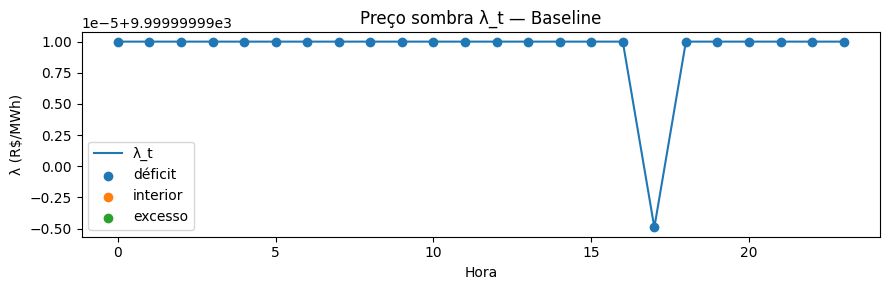

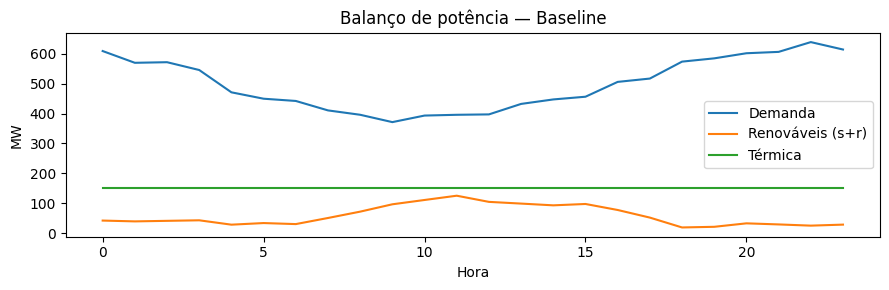

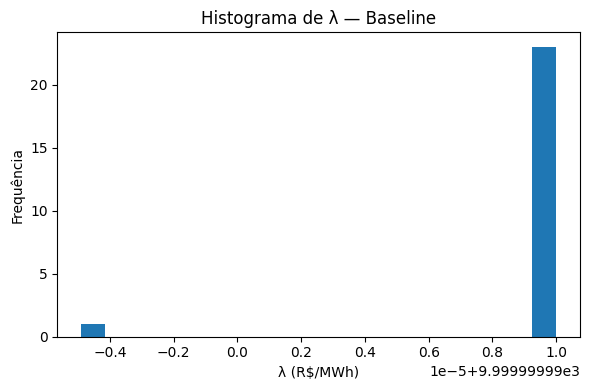

In [ ]:
base = Params(T=24, K_s=100.0, K_r=80.0, K_n=150.0, c1=200.0, c2=1.0, pi_u=10000.0, pi_c=10.0, gamma=0.0, seed=42)

# Baseline
df_base, sum_base = run_scenario(base, name="Base")
feas = check_feasibility(df_base)
kkt = kkt_diagnostics_gamma0(df_base, c1=base.c1, c2=base.c2, pi_u=base.pi_u, pi_c=base.pi_c, K_n=base.K_n)
summary_base = pd.DataFrame([sum_base | feas | kkt])

# Sweep in K_n
values_Kn = [50, 100, 150, 250, 400]
sweep_kn_df, sweep_kn_series = sweep_param(base, 'K_n', values_Kn, 'Sweep')

# Small Monte Carlo
mc_df = mc_run(base, N=100)

print(summary_base)
print(sweep_kn_df)
print(mc_df)
summary_base.to_csv("data/baseline_summary.csv", index=False)
sweep_kn_df.to_csv("data/sweep_Kn_summary.csv", index=False)
mc_df.to_csv("data/mc_100_summary.csv", index=False)

# Quick baseline plots
plot_price_regime(df_base, title="Preço sombra λ_t — Baseline")
plot_stack_power(df_base, title="Balanço de potência — Baseline")
plot_histograms(df_base, title="Histograma de λ — Baseline")



In [ ]:

def multi_sweeps(base: Params) -> dict:
    """
    Run sweeps for: K_s, K_r, K_n, pi_u, pi_c, c1, c2, gamma.
    Returns a dict of {param_name: (summary_df, dfs_dict)}.
    """
    sweeps = {}
    # Sensible grids
    grids = {
        'K_s':   [0, 50, 100, 150, 250, 400],
        'K_r':   [0, 40, 80, 120, 200, 320],
        'K_n':   [0, 50, 100, 150, 250, 400],
        'pi_u':  [2000, 5000, 10000, 20000, 40000],
        'pi_c':  [0, 5, 10, 20, 50, 100],
        'c1':    [50, 100, 200, 300, 500],
        'c2':    [0.1, 0.5, 1.0, 2.0, 5.0],
        'gamma': [0.0, 0.5, 1.0, 2.0, 5.0]
    }
    for p, vals in grids.items():
        s_df, dfs = sweep_param(base, p, vals, name_prefix="SWEEP")
        sweeps[p] = (s_df, dfs)
    return sweeps

def compute_marginal_value(summary_df: pd.DataFrame, param: str, sign: int = -1) -> pd.DataFrame:
    """
    Compute finite-difference marginal slope for cost wrt 'param'.
    Returns a new dataframe with [param, custo_total, dC_dParam, MV = -dC/dParam].
    'sign' is kept for clarity; MV is -dC/dK (cost reduction per unit of param).
    """
    df = summary_df.sort_values(param).reset_index(drop=True).copy()
    v = df[param].values.astype(float)
    C = df['custo_total'].values.astype(float)
    d = np.empty_like(v, dtype=float)
    d.fill(np.nan)
    # central differences where possible, forward/backward at edges
    for i in range(len(v)):
        if i == 0 and len(v) > 1:
            d[i] = (C[i+1] - C[i]) / (v[i+1] - v[i]) if (v[i+1] != v[i]) else np.nan
        elif i == len(v)-1 and len(v) > 1:
            d[i] = (C[i] - C[i-1]) / (v[i] - v[i-1]) if (v[i] != v[i-1]) else np.nan
        elif len(v) > 2:
            d[i] = (C[i+1] - C[i-1]) / (v[i+1] - v[i-1]) if (v[i+1] != v[i-1]) else np.nan
    df['dC_d'+param] = d
    df['MV_'+param] = sign * d  # MV = - dC/dK for capacity params
    return df[[param, 'custo_total', 'dC_d'+param, 'MV_'+param]]

def plot_marginal_curve(mv_df: pd.DataFrame, param: str, title: str = None):
    plt.figure(figsize=(6,4))
    plt.plot(mv_df[param], mv_df['MV_'+param], marker='o')
    plt.xlabel(param); plt.ylabel('Valor marginal (−dC/d'+param+')')
    if title is None:
        title = f'Curva de valor marginal — {param}'
    plt.title(title)
    plt.tight_layout(); plt.show()


Sweep K_s — custos e valor marginal


,K_s,custo_total,dC_dK_s,MV_K_s
0,0,7.834327e+07,-75014.814352,75014.814352
1,50,7.459252e+07,-75014.814352,75014.814352
2,100,7.084178e+07,-75014.814352,75014.814352
3,150,6.709104e+07,-72037.785569,72037.785569
4,250,6.003612e+07,-48767.371032,48767.371032
5,400,5.489920e+07,-34246.104268,34246.104268


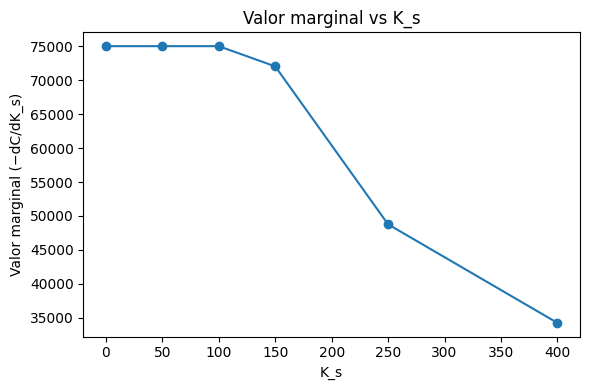

Sweep K_r — custos e valor marginal


,K_r,custo_total,dC_dK_r,MV_K_r
0,0,7.742006e+07,-82228.387665,82228.387665
1,40,7.413092e+07,-82228.387665,82228.387665
2,80,7.084178e+07,-82228.387665,82228.387665
3,120,6.755265e+07,-82228.387665,82228.387665
4,200,6.097438e+07,-82228.387665,82228.387665
5,320,5.110697e+07,-82228.387665,82228.387665


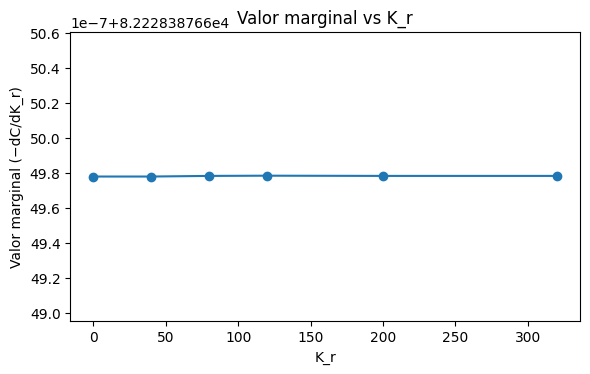

Sweep K_n — custos e valor marginal


,K_n,custo_total,dC_dK_n,MV_K_n
0,0,1.058518e+08,-234600.000000,234600.000000
1,50,9.412178e+07,-234000.000000,234000.000000
2,100,8.245178e+07,-232800.000000,232800.000000
3,150,7.084178e+07,-231000.000000,231000.000000
4,250,4.780178e+07,-200036.524570,200036.524570
5,400,2.083265e+07,-179794.207616,179794.207616


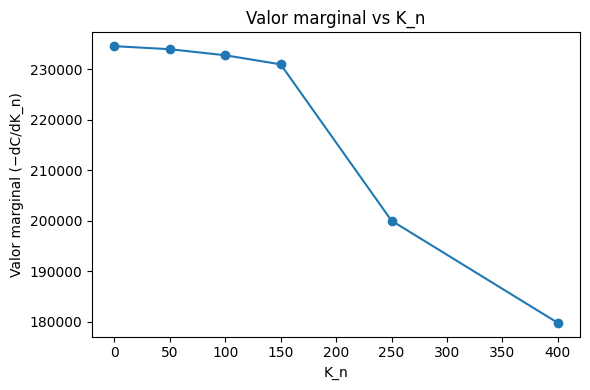

In [30]:

base = Params(T=24, K_s=100.0, K_r=80.0, K_n=150.0, c1=200.0, c2=1.0, pi_u=10000.0, pi_c=10.0, gamma=0.0, seed=42)
sweeps = multi_sweeps(base)

# Build and show marginal curves for capacity params
mv_tables = {}
for cap_param in ['K_s', 'K_r', 'K_n']:
    s_df, _ = sweeps[cap_param]
    mv = compute_marginal_value(s_df, cap_param, sign=-1)  # cost reduction per MW
    mv_tables[cap_param] = mv
    print(f"Sweep {cap_param} — custos e valor marginal")
    display(mv)

    # Plot curve
    plot_marginal_curve(mv, param=cap_param, title=f"Valor marginal vs {cap_param}")



In [31]:
def run_scenario(p: Params, name: str = "Scenario"):
    D, gs, gr = synthetic_profiles(T=p.T, K_s=p.K_s, K_r=p.K_r, seed=p.seed)
    if p.gamma > 0 and SCIPY_AVAILABLE:
        gn, u, c = solve_dispatch_numeric(D, gs, gr, K_n=p.K_n, c1=p.c1, c2=p.c2, pi_u=p.pi_u, pi_c=p.pi_c, gamma=p.gamma)
    else:
        gn, u, c = solve_dispatch_closed_form(D, gs, gr, K_n=p.K_n, c1=p.c1, c2=p.c2, pi_u=p.pi_u, pi_c=p.pi_c)
    lam = np.zeros_like(D)  # not needed for LHS importance; placeholder

    df = pd.DataFrame({'t': np.arange(p.T), 'D': D, 'g_s': gs, 'g_r': gr, 'g_n': gn, 'u': u, 'c': c, 'lambda': lam})
    summary = {
        'cenario': name, **asdict(p),
        'custo_total': cost_total(gn, u, c, c1=p.c1, c2=p.c2, pi_u=p.pi_u, pi_c=p.pi_c, gamma=p.gamma),
        'energia_nao_suprida': float(u.sum()),
        'curtailment_total': float(c.sum()),
        'lambda_medio': float(lam.mean()),
        'lambda_p95': float(np.percentile(lam, 95))
    }
    return df, summary

def latin_hypercube_samples(N: int, d: int, rng: np.random.Generator) -> np.ndarray:
    cut = (np.arange(N)[:,None] + rng.random((N, d))) / N
    H = np.zeros_like(cut)
    for j in range(d):
        order = rng.permutation(N)
        H[:, j] = cut[order, j]
    return H

def lhs_run(base: Params, N: int = 300, ranges: dict = None, seed: int = 1234) -> pd.DataFrame:
    if ranges is None:
        ranges = {
            'K_s': (50.0, 400.0),
            'K_r': (40.0, 320.0),
            'K_n': (50.0, 400.0),
            'c1':  (50.0, 500.0),
            'pi_u':(2000.0, 40000.0)
        }
    keys = list(ranges.keys())
    d = len(keys)
    rng = np.random.default_rng(seed)
    U = latin_hypercube_samples(N, d, rng)

    rows = []
    for i in range(N):
        params_scaled = {k: ranges[k][0] + U[i, j]*(ranges[k][1]-ranges[k][0]) for j, k in enumerate(keys)}
        p = Params(**{**asdict(base), **params_scaled})
        _, summary = run_scenario(p, name=f"LHS#{i}")
        for k in keys:
            summary[k] = params_scaled[k]
        rows.append(summary)
    return pd.DataFrame(rows)

def rank_importance_safe(df: pd.DataFrame, features: list, targets: list):
    out = {}
    cols_needed = list(set(features + targets))
    df2 = df.dropna(subset=cols_needed).copy()
    const_feats = [f for f in features if df2[f].std() == 0]
    feats = [f for f in features if f not in const_feats]
    meta = {'dropped_constant_features': const_feats, 'used_fallback': False}
    if len(feats) == 0:
        for y in targets:
            out[y] = pd.DataFrame({'feature': [], 'score': [], 'rank': []})
        return out, meta
    X = df2[feats].values
    X_mean = X.mean(axis=0); X_std = X.std(axis=0) + 1e-12
    Xz = (X - X_mean) / X_std
    # Try LassoCV
    try:
        from sklearn.linear_model import LassoCV
        use_l1 = True
    except Exception:
        use_l1 = False
        meta['used_fallback'] = True
    for yname in targets:
        y = df2[yname].values
        y = (y - y.mean()) / (y.std() + 1e-12)
        if use_l1:
            try:
                model = LassoCV(cv=5, random_state=0).fit(Xz, y)
                coefs = np.abs(model.coef_)
                score = coefs / (coefs.sum() + 1e-12)
            except Exception:
                meta['used_fallback'] = True
                corr = np.abs(np.corrcoef(np.c_[Xz, y].T)[-1, :-1])
                score = corr / (corr.sum() + 1e-12)
        else:
            corr = np.abs(np.corrcoef(np.c_[Xz, y].T)[-1, :-1])
            score = corr / (corr.sum() + 1e-12)
        imp = pd.DataFrame({'feature': feats, 'score': score}).sort_values('score', ascending=False).reset_index(drop=True)
        imp['rank'] = np.arange(1, len(feats)+1)
        out[yname] = imp
    return out, meta


LHS (N=300) — Summaries (SAFE, self-contained)
   cenario   T         K_s         K_r         K_n          c1   c2  \
0    LHS#0  24  209.678579  150.899721  209.544338  483.740177  1.0   
1    LHS#1  24  272.058378  100.510939  202.091714  351.324843  1.0   
2    LHS#2  24  186.603775  143.490840  293.468707  423.612421  1.0   
3    LHS#3  24   56.974064  105.233458  175.459232  376.827286  1.0   
4    LHS#4  24  312.442971  313.195146  302.867313  156.962775  1.0   
5    LHS#5  24  140.054065  186.120476  153.985423  100.245300  1.0   
6    LHS#6  24  269.043670  111.617211  213.987744  229.678320  1.0   
7    LHS#7  24  178.687205  280.333526  169.778402  201.602860  1.0   
8    LHS#8  24  150.793209  243.307648  138.541861  443.408412  1.0   
9    LHS#9  24  341.596909   96.458284  379.266706  403.436750  1.0   
10  LHS#10  24  122.597388   71.101425   81.358834  406.539525  1.0   
11  LHS#11  24  388.950195  201.848239  100.476943  394.380918  1.0   
12  LHS#12  24  336.227214  19

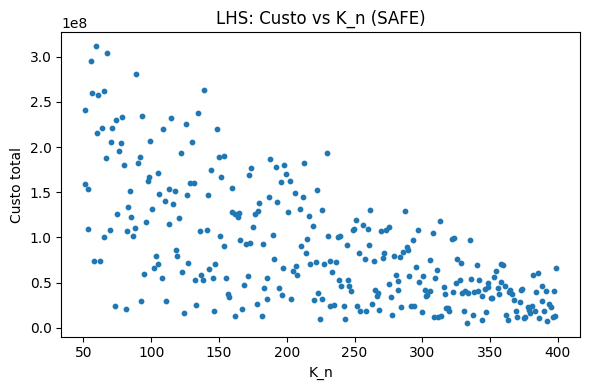

In [32]:

base = Params(T=24, K_s=100.0, K_r=80.0, K_n=150.0, c1=200.0, c2=1.0, pi_u=10000.0, pi_c=10.0, gamma=0.0, seed=42)

lhs_df = lhs_run(base, N=300)
lhs_df.to_csv("data/lhs_300_summary.csv", index=False)

print("LHS (N=300) — Summaries (SAFE, self-contained)")
print(lhs_df.head(20))

targets = ['custo_total', 'energia_nao_suprida']
features = ['K_s', 'K_r', 'K_n', 'c1', 'pi_u']

importance, meta = rank_importance_safe(lhs_df, features=features, targets=targets)
for tgt, imp_df in importance.items():
    print(f"Importância (proxy) para {tgt} — SAFE")
    print(imp_df)

stats = lhs_df[targets].agg(['mean', 'std', 'min', 'max']).T
q = lhs_df[targets].quantile([0.5, 0.9, 0.95, 0.99]).T
stats = stats.join(q, how='left')
print("Estatísticas alvo (média/disp/quantis) — SAFE")
print(stats.reset_index().rename(columns={'index':'target'}))

plt.figure(figsize=(6,4))
plt.scatter(lhs_df['K_n'].values, lhs_df['custo_total'].values, s=10)
plt.xlabel('K_n'); plt.ylabel('Custo total'); plt.title('LHS: Custo vs K_n (SAFE)')
plt.tight_layout(); plt.show()

# Save a tiny meta report
pd.DataFrame([meta]).to_csv("data/lhs_meta_report.csv", index=False)

